# **London Housing Prices - Exploratory Data Analysis**

In [London_Housing.ipynb](https://github.com/kohl-carmen/London-Housing/blob/main/London_Housing.ipynb), we had a first look at London property sales data. We found that there are large differences in house prices across the different boroughs. 

Here, we will get new data to try to predict average London house prices.

*Data provided by [London Datastore](https://data.london.gov.uk/). 
[License](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/) terms apply.*


In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor



---


# 1) Data Loading and Cleaning





First, we'll load any data which may help us predict house prices per borough (all taken from [London Datastore](https://data.london.gov.uk/)), and edit the data to make sure they're all in the same format.

For this, we'll select data with the following information per borough:
- [Average House Prices](https://data.london.gov.uk/dataset/uk-house-price-index): This is the data we're most interested in and already had a look through [here](https://github.com/kohl-carmen/London-Housing/blob/main/London_Housing.ipynb)
- [Population](https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough): Number of inhabitants
- [Area](https://data.london.gov.uk/dataset/london-borough-profiles): Land area in hectars - Unlike all other data here, area is not longitudinal  - we'll only use it to estimate population density
- [Personal Wellbeing](https://data.london.gov.uk/dataset/subjective-personal-well-being-borough): Estimates of personal well-being from the Annual Population Survey Well-being dataset
- [Crime Rates](https://data.london.gov.uk/dataset/recorded_crime_rates): Number of recorded offences
- [Employment](https://data.london.gov.uk/dataset/workless-households-borough): Proportions of households that are classified as working
- [Life expectancy](https://data.london.gov.uk/dataset/london-ward-well-being-scores): life expectancy in years
- [Childhood obesity rates](https://data.london.gov.uk/dataset/london-ward-well-being-scores): proportion of children with obesity
- [Incapacity Benefit rates](https://data.london.gov.uk/dataset/london-ward-well-being-scores): poportion of population receiving incapacity benefits
- [Unemployment rates](https://data.london.gov.uk/dataset/london-ward-well-being-scores): proportion of unemployment
- [GCSE performance](https://data.london.gov.uk/dataset/london-ward-well-being-scores): GCSE point scores
- [Absence from School](https://data.london.gov.uk/dataset/london-ward-well-being-scores): percentage of unauthorised absences from school
- [Number of children in unemployed households](https://data.london.gov.uk/dataset/london-ward-well-being-scores): percentage of children in out-of-work households
- [Transport Accessibility](https://data.london.gov.uk/dataset/london-ward-well-being-scores): public transport accessibility




These data are all longitudinal and borough-specific. However, they are formatted in a number of different ways, and contain a lot of data we will not be using. The first step is therefore to load, clean and edit the data so that all data has the same format.


In [157]:
# - load & format data: house prices - 
data_url = 'https://data.london.gov.uk/download/uk-house-price-index/70ac0766-8902-4eb5-aab5-01951aaed773/UK_House_price_index.xlsx'
df_average_price = pd.read_excel(data_url, sheet_name = 'Average price',
                                 usecols = "A:AH, AJ, AK, AM:AU, AW")
df_average_price = df_average_price.drop(df_average_price.index[0])
# format date column and make it index
df_average_price.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
df_average_price.Date = pd.to_datetime(df_average_price.Date)
df_average_price = df_average_price.set_index('Date')
# check for missing values
df_average_price. isnull().values.any()
# express in thousands
df_average_price = df_average_price.div(1000)
# standardise string formatting
for key in df_average_price:
  if key.isupper():
    newkey = key[0] + key[1:].lower()
    if ' ' in key:
      for s in range(0,len(newkey)):
        if newkey[s].isspace():
          newkey = newkey[0:s+1] + newkey[s+1].upper() + newkey[s+2:]
    df_average_price = df_average_price.rename(columns={key: newkey})
rows, columns = df_average_price.shape
df_average_price = df_average_price.iloc[:,0:33]
df_average_price = df_average_price.sort_index(axis=1)
#df_average_price.head(5)

In [158]:
# - load & format data: population-
data_url = 'https://data.london.gov.uk/download/land-area-and-population-density-ward-and-borough/cc4e7e08-3071-488f-bdd9-a62cb1ed1c5c/land-area-population-density-london.xlsx'
# load as separate dfs and join
df_pop1 = pd.read_excel(data_url, sheet_name=str('Borough staging'), 
                        usecols = "B,C,E")
df_pop2 = pd.read_excel(data_url, sheet_name=str('Borough staging'), 
                        usecols = "I,K,N")
df_pop2 = df_pop2.dropna(axis=0, how='any')
df_pop2 = df_pop2.rename(columns = {'Unnamed: 8':'Name',
                                    'Unnamed: 10':'Population',
                                    'Year.1':'Year'})
df_pop = pd.concat([df_pop1,df_pop2], axis=0)
df_pop = df_pop[df_pop.Year <= 2020] # delete future projections
# sort into df of matched format
date = pd.unique(df_pop.Year)
df_pop_format = pd.DataFrame(index = pd.unique(df_pop.Year), 
                             columns = pd.unique(df_pop.Name))
df_pop_format = df_pop_format.fillna(np.nan)
for row in range(0,len(df_pop)):
  this_borough = df_pop.Name.iloc[row]
  this_pop = df_pop.Population.iloc[row]
  this_year = df_pop.Year.iloc[row]
  row_index = np.argwhere(date==this_year)
  col_index = np.argwhere(df_pop_format.columns == this_borough) 
  df_pop_format.iloc[row_index[0],col_index[0]] = this_pop
df_pop_format = df_pop_format.drop(labels=['London','Inner London',
                                           'Outer London'], axis=1)
# edit date ans et as index
df_pop_format['Date']=''
for i in range(0,df_pop_format.shape[0]):
  df_pop_format.iloc[i,-1] = pd.to_datetime(str(int(df_pop_format.index[i]))
                                                +'0101')
df_pop_format = df_pop_format.set_index('Date')
df_population = df_pop_format.copy()
df_population = df_population.sort_index(axis=1)
#df_population.head(5)

In [159]:
# - load & format data: area -
data_url = 'https://data.london.gov.uk/download/london-borough-profiles/80647ce7-14f3-4e31-b1cd-d5f7ea3553be/london-borough-profiles.xlsx'
df_area = pd.read_excel(data_url, sheet_name = 'Data',
                                 usecols = "C,E,G,AD,")
# drop unused data
df_area = df_area.iloc[1:34]
df_area = df_area.transpose()
df_area.columns = df_area.iloc[0,:]
df_area = df_area.drop('Area name')
df_area = df_area.iloc[0:2,:]
df_area = df_area.sort_index(axis=1)
#df_area.head(5)

In [160]:
# - load & format data: wellbeing data -
data_url = 'https://data.london.gov.uk/download/subjective-personal-well-being-borough/d1bae8e8-f07b-4c2f-aec7-deed8006b52a/personal-well-being-borough.xlsx'
df_wellbeing = pd.read_excel(data_url, sheet_name = 'Summary - Mean Scores')
# edit df format
df_wellbeing = df_wellbeing.transpose()
df_wellbeing.columns = df_wellbeing.iloc[1,:]
df_wellbeing = df_wellbeing.rename(columns = {'Area': 'Date'}, inplace = False)
df_wellbeing = df_wellbeing.drop([' ', 'Unnamed: 1'])
df_wellbeing = df_wellbeing.dropna(axis=1, how = 'all')
df_wellbeing = df_wellbeing.iloc[0:8,0:34]
# edit datetime and set index
for i in range(0,len(df_wellbeing.Date)):
  df_wellbeing.Date[i] = pd.to_datetime(df_wellbeing.Date[i][0:4])
  df_wellbeing['City of London'][i] = np.nan
df_wellbeing = df_wellbeing.set_index('Date')
df_wellbeing = df_wellbeing.sort_index(axis=1)
#df_wellbeing.head(5)

In [161]:
# - load & format data: crime rates -
data_url = 'https://data.london.gov.uk/download/recorded_crime_rates/25f3c04c-898a-41c9-b911-93cac6df205f/met-police-recorded-offences-rates-borough.xlsx'
df_crime = pd.read_excel(data_url, sheet_name = 'Recorded Offences')
# edit df format
df_crime = df_crime.iloc[0:34,0:20]
df_crime = df_crime.transpose()
df_crime.columns = df_crime.iloc[1,:]
df_crime = df_crime.drop(['Unnamed: 0','Unnamed: 1'])
df_crime = df_crime.dropna(axis=1, how = 'all')
df_crime =df_crime.rename(columns = {'Borough': 'Date'})
# edit datetime and set index
for i in range(0,len(df_crime.Date)):
  df_crime.Date[i] = pd.to_datetime(df_crime.Date[i][0:4])
df_crime = df_crime.set_index('Date')
df_crime = df_crime.sort_index(axis=1)
#df_crime.head(5)

In [162]:
# - load & format data: working households -
data_url = 'https://data.london.gov.uk/download/workless-households-borough/e38fa13b-eea2-425f-a97f-52f8f722e73d/workless-households-borough.xlsx'
df_work = pd.DataFrame(columns = df_crime.columns)
df_work['Date']=''
Date = []
# load each year
for yr in range(2004, 2019+1):
  df_borough = pd.read_excel(data_url, sheet_name=str(yr), usecols = "B,D")
  df_borough = df_borough.iloc[3:36,:]
  df_borough = df_borough.transpose()
  df_borough.columns = df_borough.iloc[0,:]
  df_borough = df_borough.iloc[1,:]
  df_work = df_work.append(df_borough)
  Date.append(pd.to_datetime(str(yr)+'-01-01'))
# set datetime index
df_work['Date'] = Date
df_work = df_work.set_index('Date')
df_work[df_work=='!']=np.nan
df_work = df_work.sort_index(axis=1)
#df_work.head(5)

In [163]:
# - load & format data: several socioeconomic datasets -
data_url = 'https://data.london.gov.uk/download/london-ward-well-being-scores/45c7421c-c6de-4ffd-8484-eed623c1731d/london-ward-well-being-probability-scores.xls'
df_lifeexpectancy = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,E:I', skiprows = 628)
df_childhoodobesity = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,J:N', skiprows = 628)
df_incapacitybenefit = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,O:S', skiprows = 628)
df_unemployment = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,T:X', skiprows = 628)
df_gcse = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,AI:AM', skiprows = 628)
df_schoolabsence = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,AN:AR', skiprows = 628)
df_worklesshouseholdchildren = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,AS:AW', skiprows = 628)
df_transport = pd.read_excel(data_url, sheet_name=str('Data'), 
                        usecols = 'D,AX:BB', skiprows = 628)

# edit format
def tidy_df(df):
  df = df.iloc[:32,:]
  df = df.rename(columns={df.columns[0]:'',df.columns[1]:'2009',
                         df.columns[2]:'2010',df.columns[3]:'2011',
                         df.columns[4]:'2012',df.columns[5]:'2013'})
  df = df.transpose()
  df.index = pd.to_datetime(df.index)
  df.columns = df.iloc[0,:]
  df = df.iloc[1:,:]
  return df

df_lifeexpectancy = tidy_df(df_lifeexpectancy)
df_childhoodobesity = tidy_df(df_childhoodobesity)
df_incapacitybenefit = tidy_df(df_incapacitybenefit)
df_unemployment = tidy_df(df_unemployment)
df_gcse = tidy_df(df_gcse)
df_schoolabsence = tidy_df(df_schoolabsence)
df_worklesshouseholdchildren = tidy_df(df_worklesshouseholdchildren)
df_transport = tidy_df(df_transport)

We have now loaded all the data and made sure to put them into time-by-borough dataframes. However, they are not yet matched perfectly.

First, we'll make sure the borough labels follow the same spelling in all dataframes.

In [164]:
# Match spelling of boroughs
def rename_borough(df):
  for borough in df:
    if '&' in borough:
      index = borough.find('&')
      new_label = borough[0:index]+'and'+borough[index+1:]
      df = df.rename(columns={borough: new_label})
  return df

df_average_price = rename_borough(df_average_price)
df_population = rename_borough(df_population)
df_wellbeing = rename_borough(df_wellbeing)
df_crime = rename_borough(df_crime)
df_work = rename_borough(df_work)
df_area = rename_borough(df_area)
df_lifeexpectancy = rename_borough(df_lifeexpectancy)
df_childhoodobesity = rename_borough(df_childhoodobesity)
df_incapacitybenefit = rename_borough(df_incapacitybenefit)
df_unemployment = rename_borough(df_unemployment)
df_gcse = rename_borough(df_gcse)
df_schoolabsence = rename_borough(df_schoolabsence)
df_worklesshouseholdchildren = rename_borough(df_worklesshouseholdchildren)
df_transport = rename_borough(df_transport)

Next, we'll delete boroughs with missing values.

In [165]:
# delete borough if is missing entirely or has missing values in any set
boroughs_to_delete = []
check_df = ['df_wellbeing','df_crime','df_area','df_work','df_population',
           'df_average_price','df_lifeexpectancy','df_childhoodobesity',
           'df_incapacitybenefit','df_unemployment','df_gcse',
           'df_schoolabsence','df_worklesshouseholdchildren',
           'df_transport']
cols = df_average_price.shape[1]
for df_str in check_df:
  df = eval(df_str)
  if df.shape[1] != cols:
    for borough in df_average_price:
      if borough not in df:
        boroughs_to_delete.append(borough)

# check for missing values
for df_str in check_df:
  df = eval(df_str)
  for borough in df:
     if sum(df[borough].isna()) > 0:
       boroughs_to_delete.append(borough)

boroughs_to_delete = np.unique(boroughs_to_delete)

def delete_missing_vals(df,boroughs_to_delete):
  for delete in boroughs_to_delete:
    delete = str(delete)
    if delete in df:
      df = df.drop([delete], axis=1)
  return df

df_average_price = delete_missing_vals(df_average_price,boroughs_to_delete)
df_population = delete_missing_vals(df_population,boroughs_to_delete)
df_wellbeing = delete_missing_vals(df_wellbeing,boroughs_to_delete)
df_crime = delete_missing_vals(df_crime,boroughs_to_delete)
df_work = delete_missing_vals(df_work,boroughs_to_delete)
df_area = delete_missing_vals(df_area,boroughs_to_delete)
df_lifeexpectancy = delete_missing_vals(df_lifeexpectancy,boroughs_to_delete)
df_childhoodobesity = delete_missing_vals(df_childhoodobesity,
                                          boroughs_to_delete)
df_incapacitybenefit = delete_missing_vals(df_incapacitybenefit,
                                           boroughs_to_delete)
df_unemployment = delete_missing_vals(df_unemployment,boroughs_to_delete)
df_gcse = delete_missing_vals(df_gcse,boroughs_to_delete)
df_schoolabsence = delete_missing_vals(df_schoolabsence,boroughs_to_delete)
df_worklesshouseholdchildren = delete_missing_vals(df_worklesshouseholdchildren,
                                                   boroughs_to_delete)
df_transport = delete_missing_vals(df_transport,boroughs_to_delete)

Now the columns of all dataframes should be matched! We'll sanity-check this here:

In [166]:
# check column matching
check_df = ['df_wellbeing','df_crime','df_area','df_work','df_population',
           'df_lifeexpectancy','df_childhoodobesity',
           'df_incapacitybenefit','df_unemployment','df_gcse',
           'df_schoolabsence','df_worklesshouseholdchildren',
           'df_transport']
for col in range(0,df_average_price.shape[1]):
  borough = df_average_price.columns[col]
  for df in check_df:
    if eval(df).columns[col] != borough:
      print(df)
      print(borough)

The last step of data editing is to match the time points at which data is presented. Since all dataframes besides the one containing house prices only provide on set of data per year, we'll average house prices over months to match.






In [167]:
# match dates (most data sets only have one record per year)
# take mean per year in price data to match
df_average_price_yr = pd.DataFrame(columns=df_average_price.columns)
for yr in range(min(df_average_price.index).year,
                max(df_average_price.index).year+1):
  add = {}
  add.update({'Year':yr})
  for region in df_average_price:
    sales = df_average_price[region][df_average_price[region].index.year == yr].mean()
    add.update({region:sales})
  df_average_price_yr = df_average_price_yr.append(add,ignore_index=True)
df_average_price_yr = df_average_price_yr.set_index('Year')
df_average_price_yr['Date'] = ''
for i in range(0,df_average_price_yr.shape[0]):
  floatyear = df_average_price_yr.index[i]
  df_average_price_yr.iloc[i,-1] = pd.to_datetime(str(int(floatyear))+'0101')
df_average_price_yr = df_average_price_yr.set_index('Date')
df_average_price = df_average_price_yr.copy()
 

Unfortunately, we are unable to match the time steps perfectly, since these data were collected over differen periods of time. We'll print the years for which we have data for each set.

In [168]:
# check available dates
check_df = ['df_average_price','df_wellbeing','df_crime','df_work',
           'df_population','df_lifeexpectancy','df_childhoodobesity',
           'df_incapacitybenefit','df_unemployment','df_gcse',
           'df_schoolabsence','df_worklesshouseholdchildren',
           'df_transport']
for df_str in check_df:
  df = eval(df_str)
  print(df_str+': '+ str(df.shape[0])+ ' samples between ' + 
        str(df.index.year.min()) + ' and '+ str(df.index.year.max()))

df_average_price: 26 samples between 1995 and 2020
df_wellbeing: 8 samples between 2011 and 2018
df_crime: 18 samples between 1999 and 2016
df_work: 16 samples between 2004 and 2019
df_population: 22 samples between 1999 and 2020
df_lifeexpectancy: 5 samples between 2009 and 2013
df_childhoodobesity: 5 samples between 2009 and 2013
df_incapacitybenefit: 5 samples between 2009 and 2013
df_unemployment: 5 samples between 2009 and 2013
df_gcse: 5 samples between 2009 and 2013
df_schoolabsence: 5 samples between 2009 and 2013
df_worklesshouseholdchildren: 5 samples between 2009 and 2013
df_transport: 5 samples between 2009 and 2013




---


# 2) Data Inspection & Feature Engineering

Now that we've formatted all the data, we can change them into more meaningful measures where applicable: we'll normalise crime rates by population and transform population data into population density data.

In [169]:
# calculate population density
df_population = df_population.divide(df_area.iloc[1,:])

# crime numbers/population
features.crime = features.crime.divide(features.population)

Now that the data is ready, we'll plot each set to check that everything looks sensible.

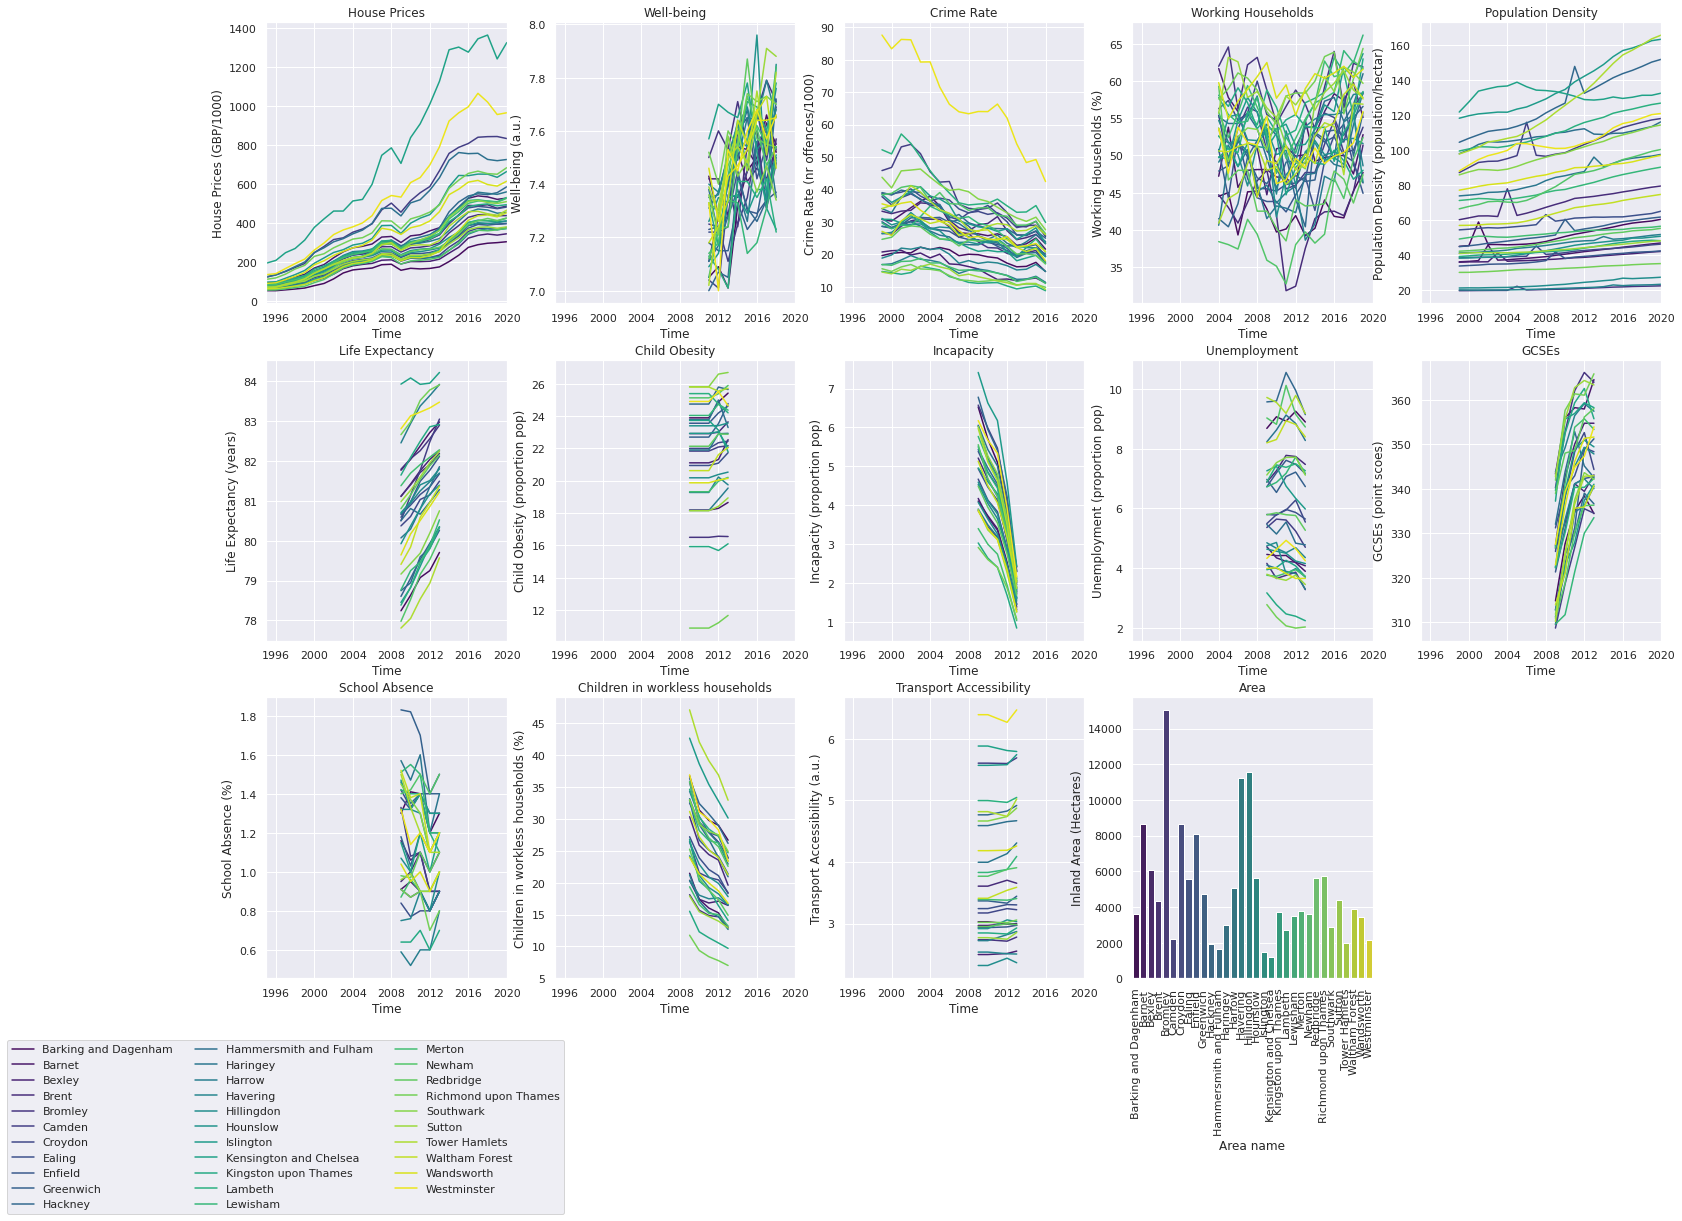

In [170]:
def plot_all(df):
  count = 0
  my_cmap = sns.color_palette('viridis', n_colors = len(list(df)))
  for borough in df:
    plt.plot(df[borough], color = my_cmap[count])
    count += 1

sns.set(rc={'figure.figsize':(25,30)})
cont_df = ['df_average_price','df_wellbeing','df_crime','df_work',
           'df_population','df_lifeexpectancy','df_childhoodobesity',
           'df_incapacitybenefit','df_unemployment','df_gcse',
           'df_schoolabsence','df_worklesshouseholdchildren',
           'df_transport']
df_titles = ['House Prices','Well-being','Crime Rate',
             'Working Households','Population Density','Life Expectancy',
             'Child Obesity','Incapacity','Unemployment','GCSEs',
             'School Absence','Children in workless households',
             'Transport Accessibility']
df_units = ['GBP/1000','a.u.','nr offences/1000','%','population/hectar',
            'years','proportion pop','proportion pop','proportion pop',
            'point scoes','%','%','a.u.']

count = 0
for df_str in cont_df:
  df = eval(df_str)
  if  df_str=='df_crime':
    df = df.div(1000)
  count += 1
  plt.subplot(5,5,count)
  plot_all(df)
  plt.title(df_titles[count-1])
  plt.xlim([pd.to_datetime(str(1995)+'0101'),pd.to_datetime(str(2020)+'0101')])
  plt.ylabel(df_titles[count-1]+ ' (' + df_units[count-1]+')')
  plt.xlabel('Time')
plt.legend(df.columns,bbox_to_anchor = (-3.5, -.2),ncol = 3, loc='upper left')

plt.subplot(5,5,count+1)
bars = sns.barplot(x=df_area.columns,y = df_area.iloc[1,:], palette='viridis')
bars.set_title('Area')
_ = bars.set_xticklabels(bars.get_xticklabels(),rotation=90)



To get a sense of the overall trend of each dataset, we'll plot the same figure again with an overlaid average.

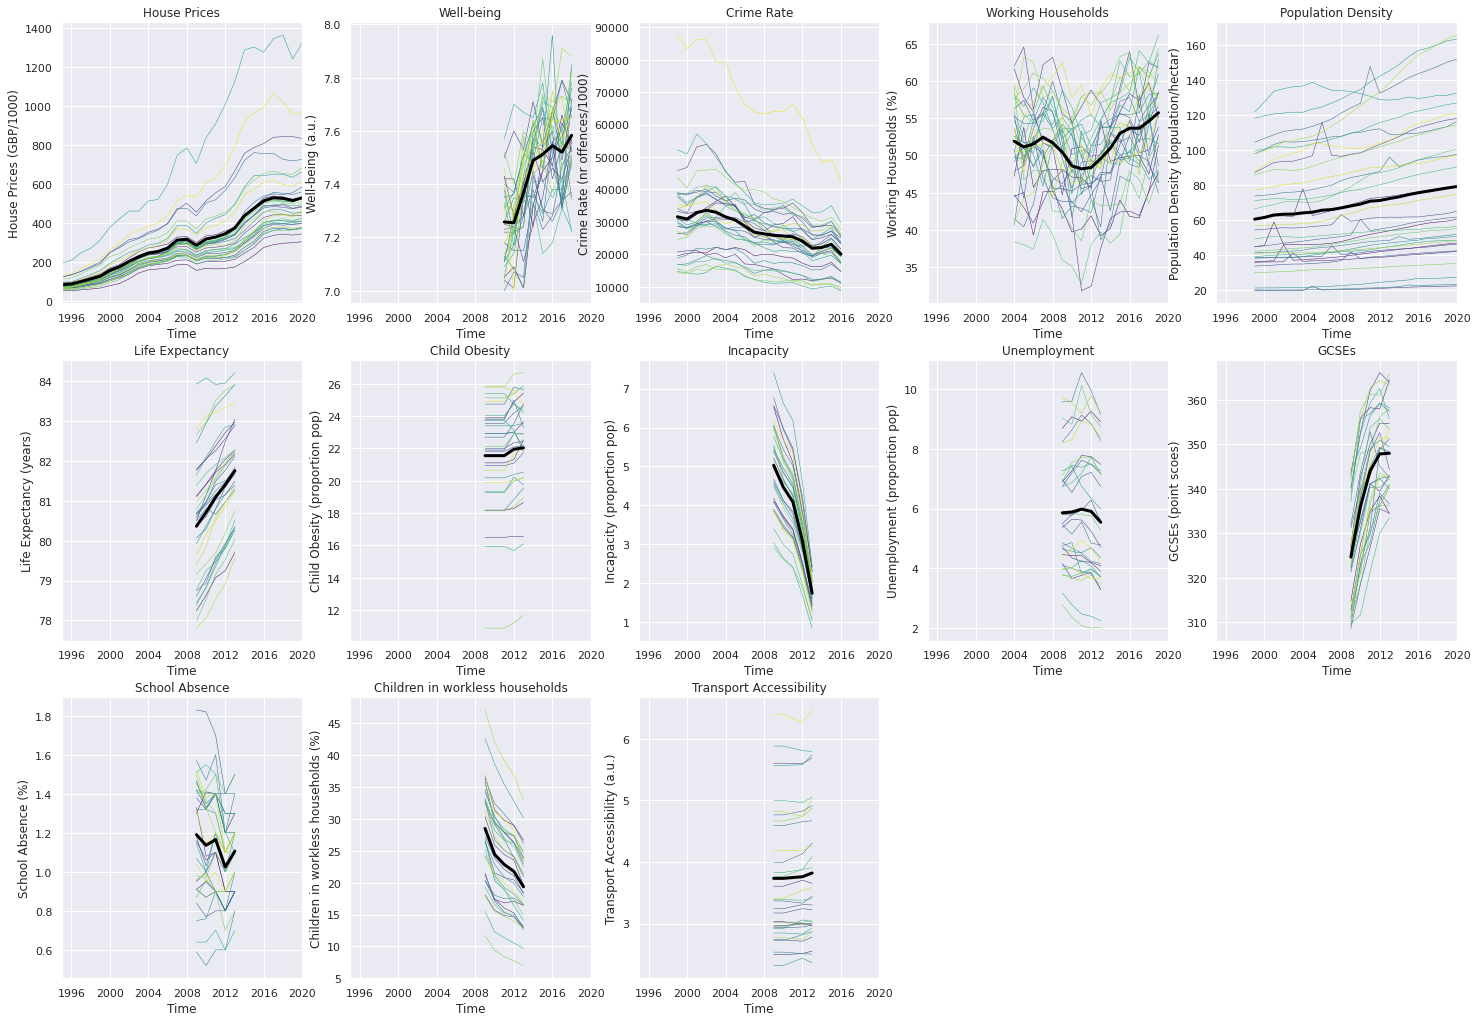

In [171]:
#repeat figure and add mean
def plot_all(df):
  count = 0
  my_cmap = sns.color_palette('viridis', n_colors = len(list(df)))
  for borough in df:
    plt.plot(df[borough], linewidth=0.5, color = my_cmap[count])
    count += 1

sns.set(rc={'figure.figsize':(25,30)})
count = 0

for df_str in cont_df:
  df = eval(df_str)
  count += 1
  plt.subplot(5,5,count)
  plot_all(df)
  #plot_avg
  plt.plot(df.mean(axis=1),color=[0,0,0],linewidth=3)
  plt.title(df_titles[count-1])
  plt.xlim([pd.to_datetime(str(1995)+'0101'),pd.to_datetime(str(2020)+'0101')])
  plt.ylabel(df_titles[count-1]+ ' (' + df_units[count-1]+')')
  plt.xlabel('Time')

We can see that all data looks sensible. However, we can also see that most data does not span many years. 

Next, we'll explore the relationship between each dataset and London house prices for all years in which data is available.

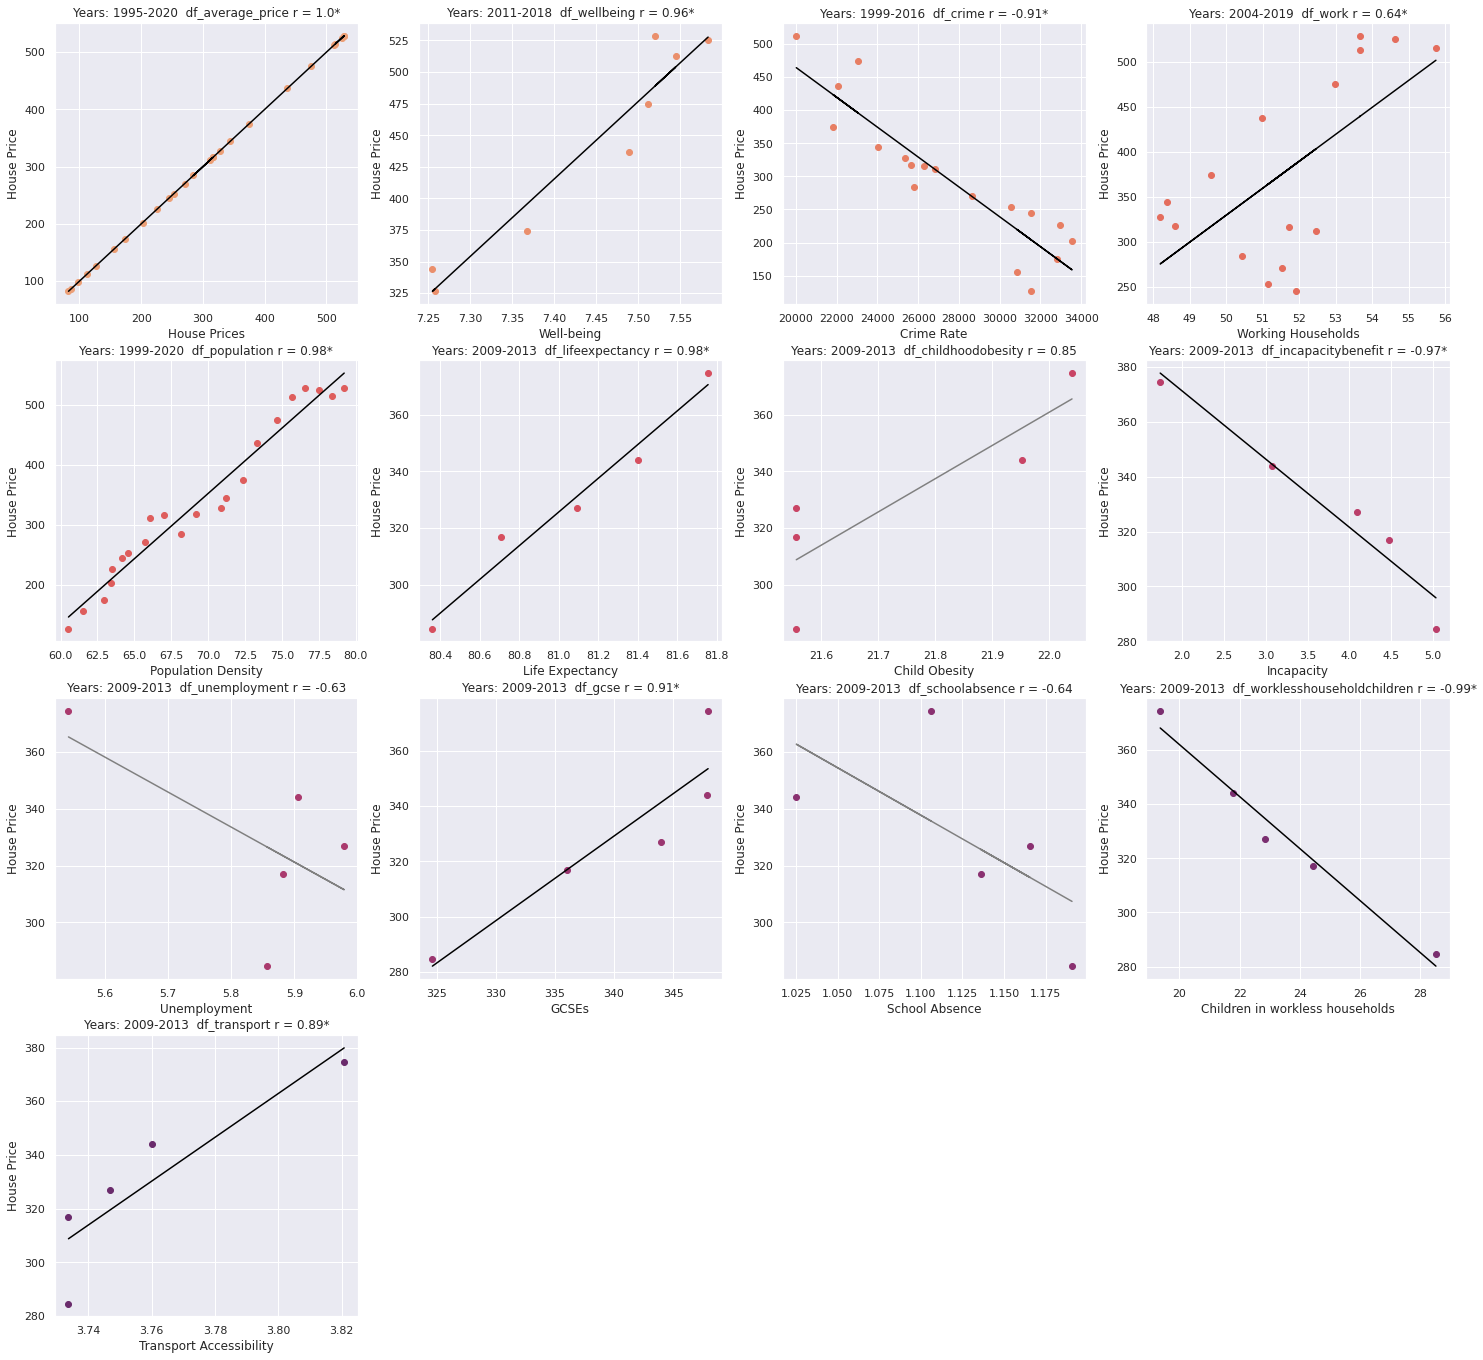

In [172]:
# plot house prices as a function of each variable
sns.set(rc={'figure.figsize':(25,30)})
my_cmap = sns.color_palette('flare', n_colors = len(cont_df)+1)

def select_matching_years_and_avg(df):
  # find years available in both sets
  shared_min = np.max([df_average_price.index.year.min(), df.index.year.min()])
  shared_max = np.min([df_average_price.index.year.max(), df.index.year.max()])
  price_slice = df_average_price[(df_average_price.index.year >= shared_min) &
                                 (df_average_price.index.year <= shared_max)]
  df_slice = df[(df.index.year >= shared_min) & (df.index.year <= shared_max)]
  df_x = df_slice.mean(axis=1)
  df_y = price_slice.mean(axis=1) 
  return df_x, df_y

# plot bivariate correlations
count = 0
for df_str in cont_df:
  count += 1
  plt.subplot(5,4,count)
  df = eval(df_str)
  df_x, df_y = select_matching_years_and_avg(df)
  plt.scatter(df_x,df_y,color=my_cmap[count-1])
  corr, p = pearsonr(df_x,df_y)
  trendcolor = [.5, .5, .5]
  pstr = ''
  if p < .05:
    trendcolor = [0, 0, 0]
    pstr = '*'
  plt.title('Years: '+ str(df.index.year.min()) +'-'+ str(df.index.year.max())+
            '  '+ cont_df[count-1] + ' r = ' + str(round(corr,2))+pstr)
  plt.xlabel(df_titles[count-1])
  plt.ylabel('House Price')
  trend = np.polyfit(np.array(df_x, dtype='float'),
                    np.array(df_y, dtype='float'),1)
  trendpoly = np.poly1d(trend)
  plt.plot(df_x,trendpoly(df_x),color=trendcolor)


We can see that most variables seem somewhat related to London house prices. 
In particular, we can see a strong negative relationship between house prices and crime rates, and a strong positive relationship between house prices and population density. This is unsurprising as safe areas with a high demand for housing drive up prices (but see below).


However, it is now obvious that for most datasets, we do not have enough data to assess it as longitudinal data. Going forward, we'll therefore get rid of the time dimension by picking the latest year shared by all datasets. We'll then test whether some of our variables can predict house prices.



---
# 3) Feature Selection



We'll use a linear regression model to test whether out variables are able to predict housing prices for different boroughs.

We'll select all data for a specific year and combine all data which we believe may help us predict London house prices into one feature dataframe.

In [179]:
def find_latest_shared_year(feature_str,target_str):
  # find latest shared year
  shared_max = 99999
  feature_target_str = feature_str + target_str
  for variable in feature_target_str:
    df = eval(variable)
    shared_max = np.min([df.index.year.max(), shared_max])
  return shared_max

def drop_and_concat(feature_str,shared_max):
  # drop all other years & concatenate features
  features = pd.DataFrame()
  for feature in feature_str:
    df = eval(feature)
    df = df[(df.index.year == shared_max)]   
    df = df.transpose()   
    df = df.rename(columns={df.columns[0]: feature[3:]})
    features = pd.concat([features,df], axis=1)
  return features

#select features
feature_str = ['df_wellbeing','df_crime','df_work','df_population',
               'df_lifeexpectancy','df_childhoodobesity',
               'df_incapacitybenefit','df_unemployment','df_gcse',
               'df_schoolabsence', 'df_worklesshouseholdchildren',
               'df_transport']
target_str = ['df_average_price']

# pick year of interest
year = find_latest_shared_year(feature_str,target_str)
features = drop_and_concat(feature_str,year)
target = drop_and_concat(target_str,year)

features = features.astype(float)
target = target.astype(float)

Inspect relationship between house prices and each of the variables.

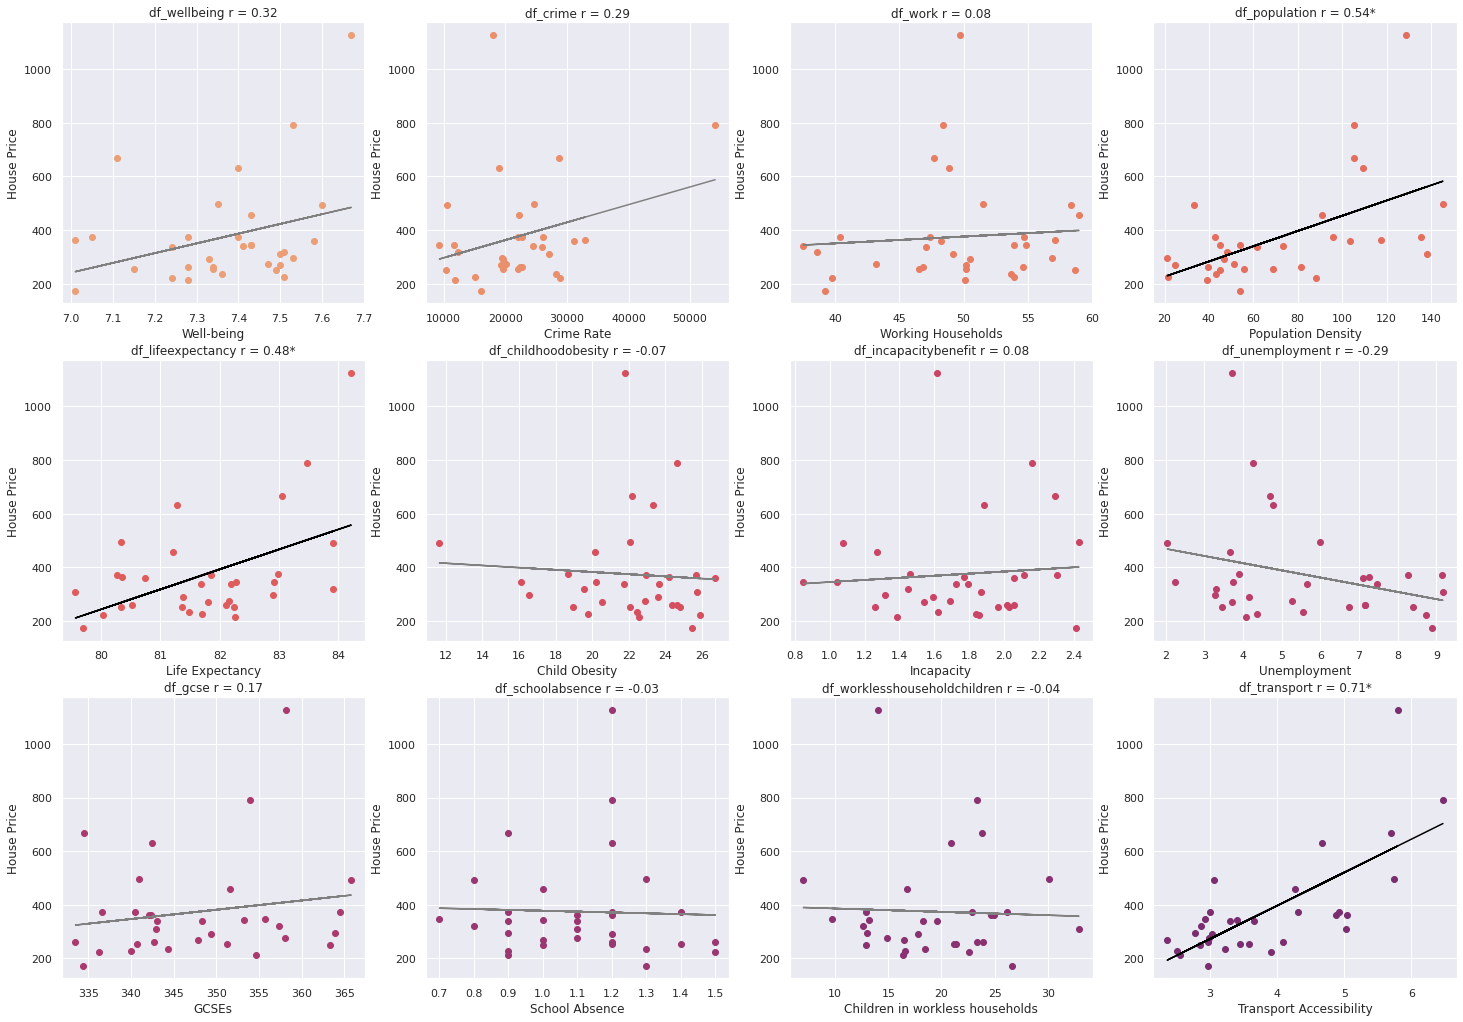

In [180]:
# each feature with target
sns.set(rc={'figure.figsize':(25,30)})
my_cmap = sns.color_palette('flare', n_colors = len(cont_df)+1)

count = 0
for feature in features:
  count += 1
  plt.subplot(5,4,count)
  df_x = features[feature]
  df_y = target.average_price
  plt.scatter(df_x,df_y,color=my_cmap[count-1])
  corr, p = pearsonr(df_x,df_y)
  trendcolor = [.5, .5, .5]
  pstr = ''
  if p < .05:
    trendcolor = [0, 0, 0]
    pstr='*'
  plt.title(cont_df[count] + ' r = ' + str(round(corr,2))+pstr)
  plt.xlabel(df_titles[count])
  plt.ylabel('House Price')
  trend = np.polyfit(np.array(df_x, dtype='float'),
                    np.array(df_y, dtype='float'),1)
  trendpoly = np.poly1d(trend)
  plt.plot(df_x,trendpoly(df_x),color=trendcolor)


Now that we're looking at the relationship between each feature and house prices per borough for one year (rather than per year, averaged over boroughs as in the plot above), we can see that some of the relationships have disappeared or even reversed (e.g. population density). 
Comparing all figures so far, it seems like on the one hand, population density and house prices show a strong *positive* relationship over time as they both increase on average. On the other hand, population density at a given time has a *negative* relationship with house prices for a specific borough.

Based on these correlations alone, it seems that transport accessibility, life expectancy, crime rates, and population densities have the strongest relationship with housing prices.



We expect that some of our features are related to each other (e.g. unemployment - employment). Since this can cause problems for our regression model, we'll first check for mutlicollinearity by plotting bivariate relationships between each set of features and by inspecting the variance inflation factor.

Variance inflation factor per feature:


,feature,VIF
0,wellbeing,3456.885282
1,crime,34.488685
2,work,151.641820
3,population,138.143584
4,lifeexpectancy,8197.205349
5,childhoodobesity,261.692468
6,incapacitybenefit,147.366800
7,unemployment,58.822356
8,gcse,5263.094543
9,schoolabsence,93.431358


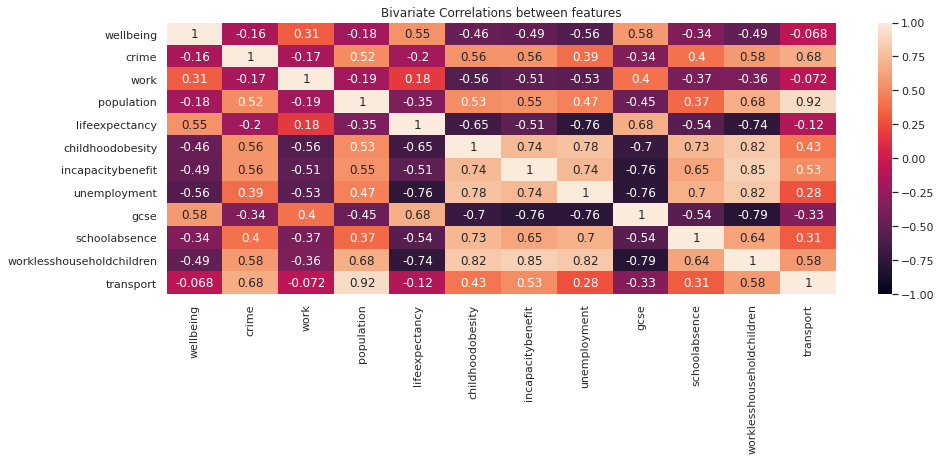

In [181]:
# Check multicollinearity

#bivariate correlations
sns.set(rc={'figure.figsize':(15,5)})
sns.heatmap(features.astype(float).corr(),vmin=-1,vmax=1,annot=True)
plt.title('Bivariate Correlations between features')
  
# variance inflation factor 
variance_inflation = pd.DataFrame() 
variance_inflation["feature"] = features.columns 
variance_inflation["VIF"] = [variance_inflation_factor(features.values, i) 
                             for i in range(len(features.columns))] 
print('Variance inflation factor per feature:')
variance_inflation

Wecan see that have large variance inflation factors and strong relationships between many of the features, some of which are a little unexpected (e.g. tranport accessibility and crime rates) while others were anticipated (e.g. unemployment rates and children in unemployed households).

We will delete some of these features and repeat the multicollinearity analysis.


Variance inflation factor per feature:


,feature,VIF
0,crime,21.398993
1,population,74.556877
2,childhoodobesity,110.738888
3,incapacitybenefit,100.918211
4,unemployment,52.417540
5,schoolabsence,81.316059
6,worklesshouseholdchildren,96.299173
7,transport,214.614117


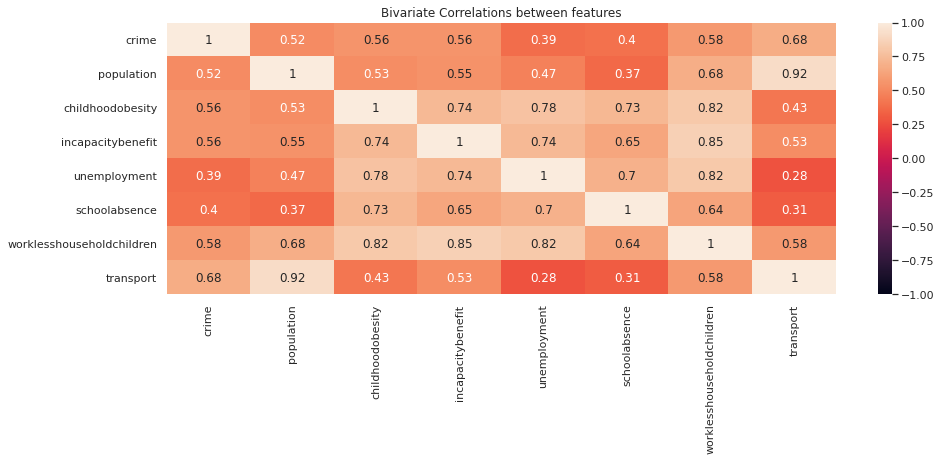

In [182]:
#remove worst features and re-assess
features = features.drop(columns=['gcse','lifeexpectancy','wellbeing','work'])

#bivariate correlations
sns.set(rc={'figure.figsize':(15,5)})
sns.heatmap(features.astype(float).corr(),vmin=-1,vmax=1,annot=True)
plt.title('Bivariate Correlations between features')
  
# variance inflation factor 
variance_inflation = pd.DataFrame() 
variance_inflation["feature"] = features.columns 
variance_inflation["VIF"] = [variance_inflation_factor(features.values, i) 
                          for i in range(len(features.columns))] 
print('Variance inflation factor per feature:')
variance_inflation

We can see that removing these features helped, but there is still a multicollinearity problem. To avoid losing more data, we will therefore select a ridge regression model, which is less affected by mutlicollinearity.



---
# 4) Regression



Mean Absolute Error: 60.62174727429228
Mean Squared Error: 4899.633431597548
Root Mean Squared Error: 69.99738160529684


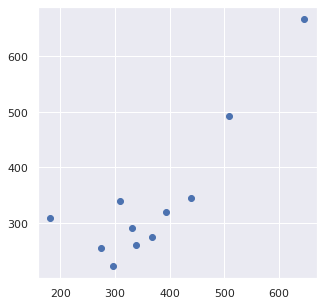

In [107]:
X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.33)

regr = linear_model.Ridge()
regr.fit(X_train, y_train)
# plt.subplot(1,2,1)
sns.set(rc={'figure.figsize':(5,5)})
#plt.scatter(X_train,y_train)
y_pred = regr.predict(X_test)
plt.scatter(y_pred,y_test)
# coeff_df = pd.DataFrame(regr.coef_, features.columns, columns=['Coefficient'])
# coeff_df

# df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# df

test_set_rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))

test_set_r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [108]:
... tbc....